# Analysis of CiDiff


## Imports and configuration

In [36]:
import numpy as np
import pandas as pd
import plotnine as pn
import mizani as mi
import mizani.transforms as tr
import statsmodels as sm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pn.theme_set(pn.theme_minimal())

print("Numpy: %s"%np.__version__)
print("Pandas: %s"%pd.__version__)
print("Plotnine: %s"%pn.__version__)
print("Mizani: %s"%mi.__version__)
print("statsmodels: %s"%sm.__version__)

Numpy: 2.2.1
Pandas: 2.2.3
Plotnine: 0.14.5
Mizani: 0.13.1
statsmodels: 0.14.4


In [66]:
def order(df, col):
    l = df[col].value_counts().index.to_list()
    l.reverse()
    c = pd.Categorical(df[col], categories=l)
    df[col] = c
    return df

In [37]:
DATASET_FILE = "./dataset.csv"
BENCHMARK_FILE = "./benchmark.csv"
SURVEY_FILE = "./survey.csv"

## Dataset Analysis

In [38]:
dataset = pd.read_csv(DATASET_FILE, sep=',')
dataset["total_size"] = dataset["success"] + dataset["failure"]
dataset.head()

,repository,run,language,success,failure,total_size
0,stimulusreflex/cable_ready,run456-0,Ruby,585,603,1188
1,stimulusreflex/cable_ready,run740-0,Ruby,579,498,1077
2,yogeshojha/rengine,run1445-0,JavaScript,62,67,129
3,marcominerva/chatgptnet,run35-0,C#,740,750,1490
4,determinatesystems/nix-installer,run1008-0,Rust,929,550,1479


In [39]:
print(len(dataset))
print(len(set(dataset["repository"].to_list())))
print(len(set(dataset["language"].to_list())))

17906
7955
20


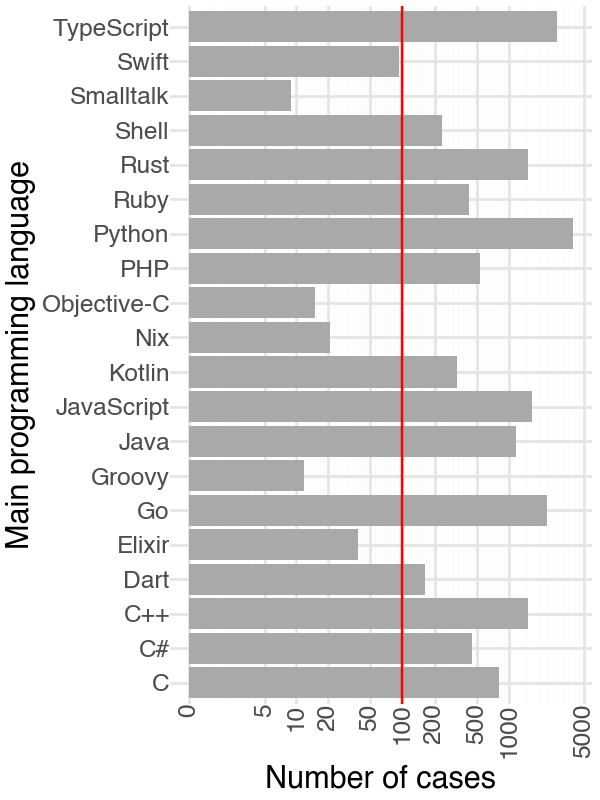

In [103]:
plot = pn.ggplot(dataset, pn.aes(x="language")) + pn.geom_bar(fill="darkgrey") + pn.theme(axis_text_x = pn.element_text(angle = 90)) + pn.scale_y_continuous(trans=tr.pseudo_log_trans(base=10), breaks=[0, 5, 10, 20, 50, 100, 200, 500, 1000, 5000]) + pn.xlab("Main programming language") + pn.ylab("Number of cases") + pn.geom_hline(yintercept=100, color="red") + pn.coord_flip() + pn.theme(figure_size=(3, 4))
plot.save("main_language_per_case.pdf", verbose=False)
plot


In [41]:
dataset["language"].value_counts().to_frame()

,count
language,
Python,3930
TypeScript,2782
Go,2271
JavaScript,1653
Rust,1514
C++,1495
Java,1149
C,807
PHP,528


In [42]:
len(set(dataset["repository"].to_list()))

7955

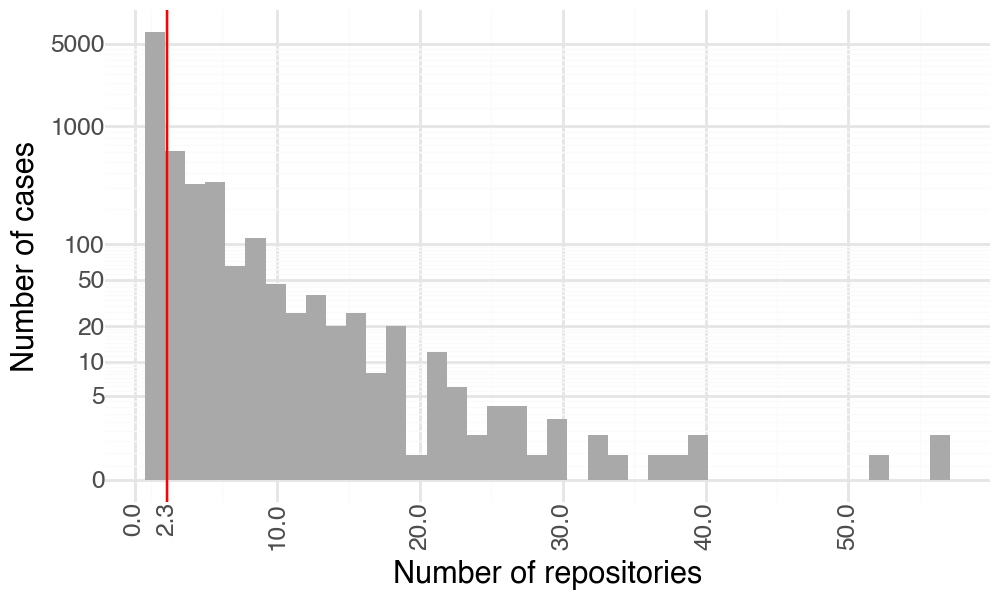

In [98]:
projects = dataset["repository"].value_counts().to_frame()
plot = pn.ggplot(projects, pn.aes(x="count")) + pn.geom_histogram(bins=40, fill="darkgrey") + pn.geom_vline(xintercept=projects["count"].mean(), color="red") + pn.scale_y_continuous(trans=tr.pseudo_log_trans(base=10), breaks=[0, 5, 10, 20,50, 100, 1000, 5000]) + pn.ylab("Number of cases") + pn.scale_x_continuous(breaks=[0, projects["count"].mean(), 10, 20, 30, 40, 50, 60]) +  pn.xlab("Number of repositories") + pn.theme(axis_text_x = pn.element_text(angle = 90), figure_size=(5, 3))
plot.save("cases_per_project.pdf", verbose=False)
plot

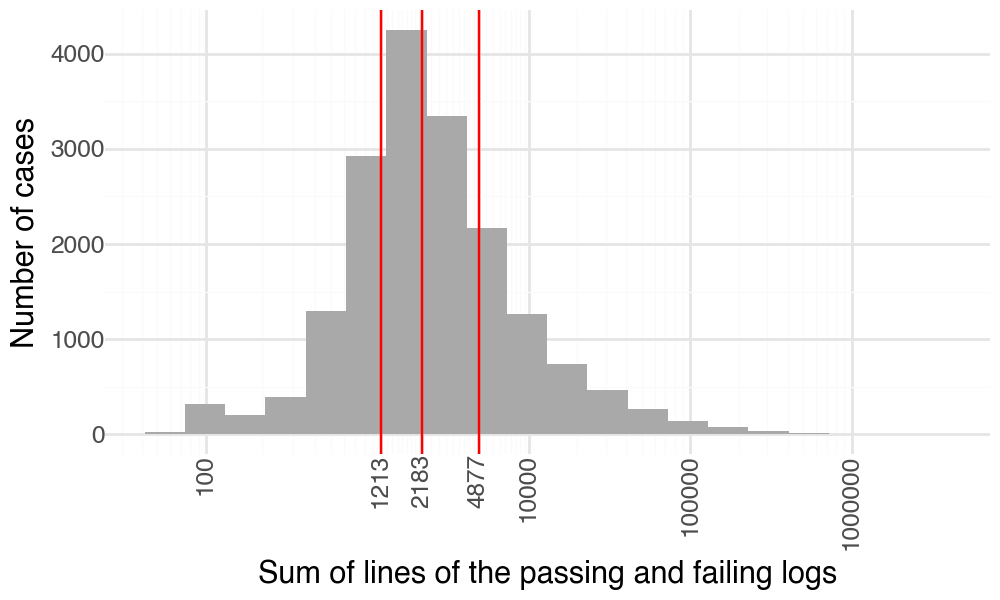

In [97]:
plot = pn.ggplot(dataset, pn.aes(x="total_size")) + pn.geom_histogram(bins=20, fill="darkgrey") + pn.scale_x_continuous(trans=tr.pseudo_log_trans(base=10), breaks=[0,1,10,100,dataset["total_size"].quantile(0.25),dataset["total_size"].quantile(0.5),dataset["total_size"].quantile(0.75),10000,100000,1000000]) + pn.geom_vline(xintercept=dataset["total_size"].quantile(0.5), color="red") + pn.geom_vline(xintercept=dataset["total_size"].quantile(0.25), color="red") + pn.geom_vline(xintercept=dataset["total_size"].quantile(0.75), color="red") + pn.ylab("Number of cases") + pn.xlab("Sum of lines of the passing and failing logs") + pn.theme(axis_text_x = pn.element_text(angle = 90), figure_size=(5,3))
plot.save("total_lines_per_case.pdf", verbose=False)
plot

## Benchmark Results Analysis

In [45]:
data = pd.read_csv(BENCHMARK_FILE, sep=',')
data.head()

,directory,type,duration,lines-left,lines-right,actions,added,deleted,updated,moved-unchanged,moved-updated,similar-groups,similar-groups-left,similar-groups-right
0,stimulusreflex/cable_ready/run456-0,seed,5.8,577,588,42,18,7,17,0,0,65,31,34
1,stimulusreflex/cable_ready/run456-0,lcs,1.1,577,588,59,35,24,0,0,0,64,31,33
2,stimulusreflex/cable_ready/run740-0,seed,3.9,576,496,107,9,89,9,0,0,48,25,23
3,stimulusreflex/cable_ready/run740-0,lcs,2.6,576,496,116,18,98,0,0,0,48,25,23
4,yogeshojha/rengine/run1445-0,seed,0.6,59,64,5,5,0,0,0,0,4,1,3


In [46]:
REFERENCE_TYPE = "lcs"
ALTERNATE_TYPES = ["seed"]
REFERENCE_SUFFIX = "-" + REFERENCE_TYPE

In [47]:
data[data["duration"] == -1.0].groupby("type").count()["duration"].to_frame()

,duration
type,
lcs,81
seed,80


In [48]:
print(set(data[data["duration"] == -1.0][data["type"] == "lcs"]["directory"].to_list()) - set(data[data["duration"] == -1.0][data["type"] == "seed"]["directory"].to_list()))
print(set(data[data["duration"] == -1.0][data["type"] == "seed"]["directory"].to_list()) - set(data[data["duration"] == -1.0][data["type"] == "lcs"]["directory"].to_list()))

{'roehling/postsrsd/run48-0', 'nao1215/gup/run43-0'}
{'bforartists/bforartists/run284-0'}


/var/folders/n_/dlsgjw2d6g96px8dr37bp7jc0000gn/T/ipykernel_88233/1200980711.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/var/folders/n_/dlsgjw2d6g96px8dr37bp7jc0000gn/T/ipykernel_88233/1200980711.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/var/folders/n_/dlsgjw2d6g96px8dr37bp7jc0000gn/T/ipykernel_88233/1200980711.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/var/folders/n_/dlsgjw2d6g96px8dr37bp7jc0000gn/T/ipykernel_88233/1200980711.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [49]:
TIMEOUTS = set(data[data["duration"] == -1.0]["directory"].to_list())
data = data[~data["directory"].isin(TIMEOUTS)]

In [105]:
ref_data = data[data["type"] == REFERENCE_TYPE][["directory", "duration", "actions", "added"]]
print(len(ref_data))

variant_data = data[data["type"].isin(ALTERNATE_TYPES)]
merged_data = variant_data.merge(ref_data, left_on="directory", right_on="directory", how="left", suffixes=["", REFERENCE_SUFFIX])

merged_data["duration-diff"] = 100 * (merged_data["duration"] - merged_data["duration" + REFERENCE_SUFFIX]) / (merged_data["duration" + REFERENCE_SUFFIX] + 1)

merged_data["duration-absdiff"] = merged_data["duration"] - merged_data["duration-lcs"]
                                                                        
merged_data["actions-diff"] = 100 * (merged_data["actions"] - merged_data["actions" + REFERENCE_SUFFIX]) / (merged_data["actions" + REFERENCE_SUFFIX] + 1)

merged_data["added-diff"] = 100 * (merged_data["added"] - merged_data["added" + REFERENCE_SUFFIX]) / (merged_data["added" + REFERENCE_SUFFIX] + 1) 

merged_data["lines-all"] = merged_data["lines-left"] + merged_data["lines-right"]

bins = [0, 100, 1000, 10000, 100000, float('inf')]
labels = ['0-100', '100-1000', '1000-10000', '10000-100000', '100000+']
merged_data['lines_all_bins'] = pd.cut(merged_data['lines-all'], bins=bins, labels=labels, right=False)

merged_data.head()


17824


,directory,type,duration,lines-left,lines-right,actions,added,deleted,updated,moved-unchanged,moved-updated,similar-groups,similar-groups-left,similar-groups-right,duration-lcs,actions-lcs,added-lcs,duration-diff,duration-absdiff,actions-diff,added-diff,lines-all,lines_all_bins
0,stimulusreflex/cable_ready/run456-0,seed,5.8,577,588,42,18,7,17,0,0,65,31,34,1.1,59,35,223.809524,4.7,-28.333333,-47.222222,1165,1000-10000
1,stimulusreflex/cable_ready/run740-0,seed,3.9,576,496,107,9,89,9,0,0,48,25,23,2.6,116,18,36.111111,1.3,-7.692308,-47.368421,1072,1000-10000
2,yogeshojha/rengine/run1445-0,seed,0.6,59,64,5,5,0,0,0,0,4,1,3,0.3,5,5,23.076923,0.3,0.000000,0.000000,123,100-1000
3,marcominerva/chatgptnet/run35-0,seed,15.6,740,745,602,102,97,403,0,0,134,66,68,43.4,1005,505,-62.612613,-27.8,-40.059642,-79.644269,1485,1000-10000
4,determinatesystems/nix-installer/run1008-0,seed,11.4,903,542,403,12,373,16,2,0,62,31,31,8.5,421,30,30.526316,2.9,-4.265403,-58.064516,1445,1000-10000


In [51]:
merged_data.groupby("type")[["actions-diff","added-diff", "duration-diff"]].median()

,actions-diff,added-diff,duration-diff
type,,,
seed,-20.765971,-60.212538,11.892975


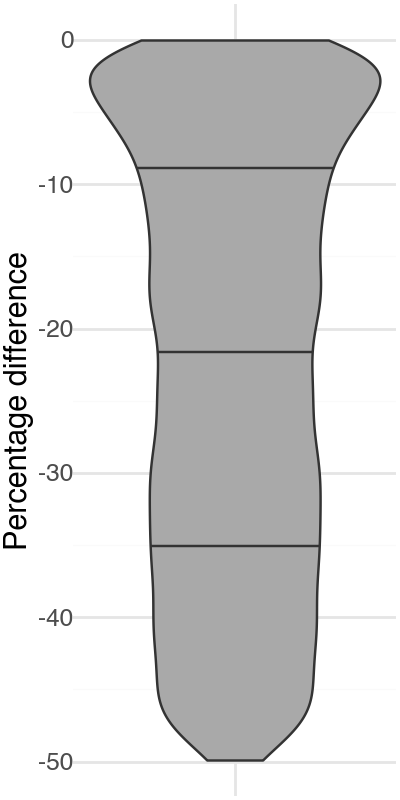

In [107]:
plot = pn.ggplot(merged_data, pn.aes(x="type", y="actions-diff")) + pn.geom_violin(fill="darkgrey", draw_quantiles=[0.25,0.5,0.75]) + pn.ylab("Percentage difference") + pn.xlab("") + pn.theme(axis_text_x=pn.element_blank(), figure_size=(2,4))
# plot.save(filename="actions_diff.pdf")
plot

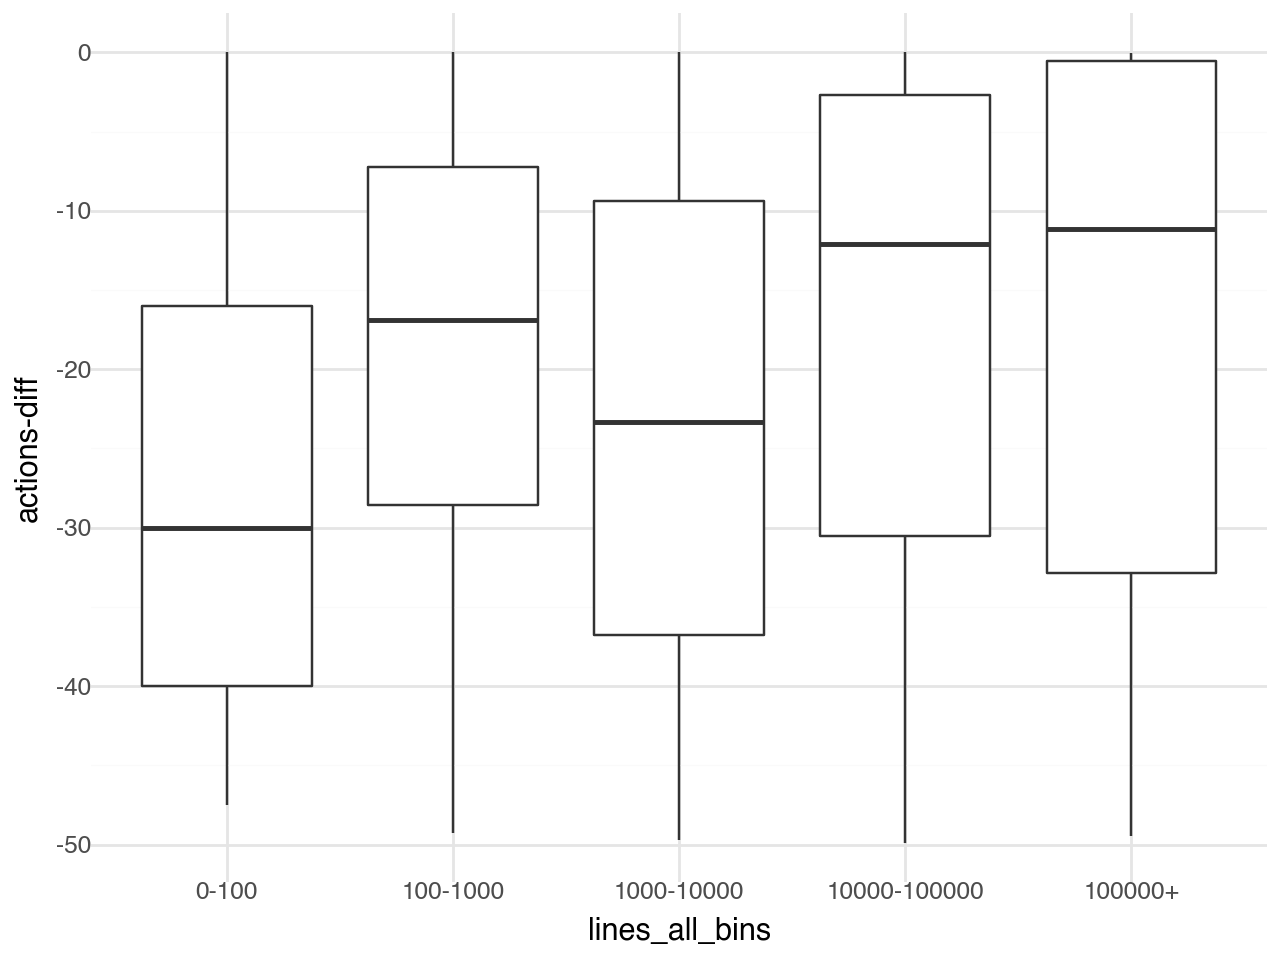

In [106]:
pn.ggplot(merged_data, pn.aes(x='lines_all_bins', y='actions-diff')) + pn.geom_boxplot() + pn.theme_minimal()

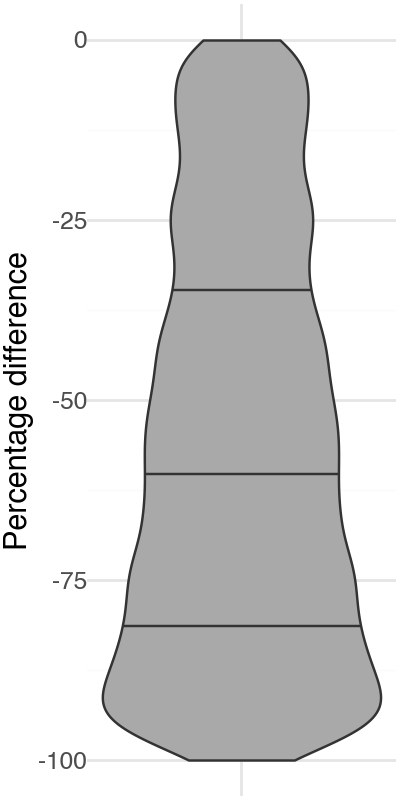

In [91]:
plot = pn.ggplot(merged_data, pn.aes(x="type", y="added-diff")) + pn.geom_violin(fill="darkgrey", draw_quantiles=[0.25,0.5,0.75]) + pn.ylab("Percentage difference") + pn.xlab("") + pn.theme(axis_text_x=pn.element_blank(), figure_size=(2, 4))
# plot.save(filename="added_diff.pdf", verbose=False)
plot

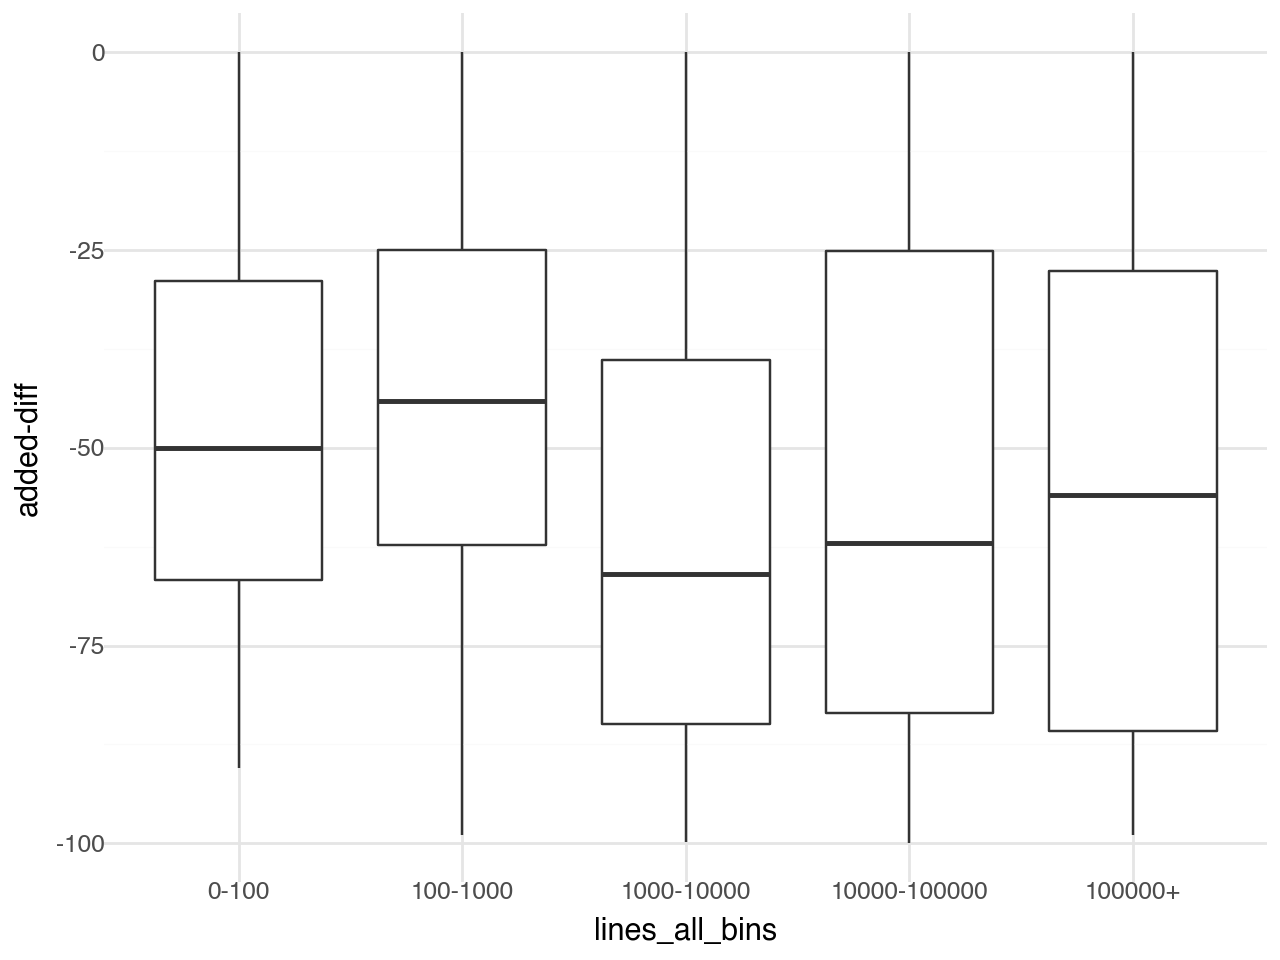

In [108]:
pn.ggplot(merged_data, pn.aes(x='lines_all_bins', y='added-diff')) + pn.geom_boxplot() + pn.theme_minimal()

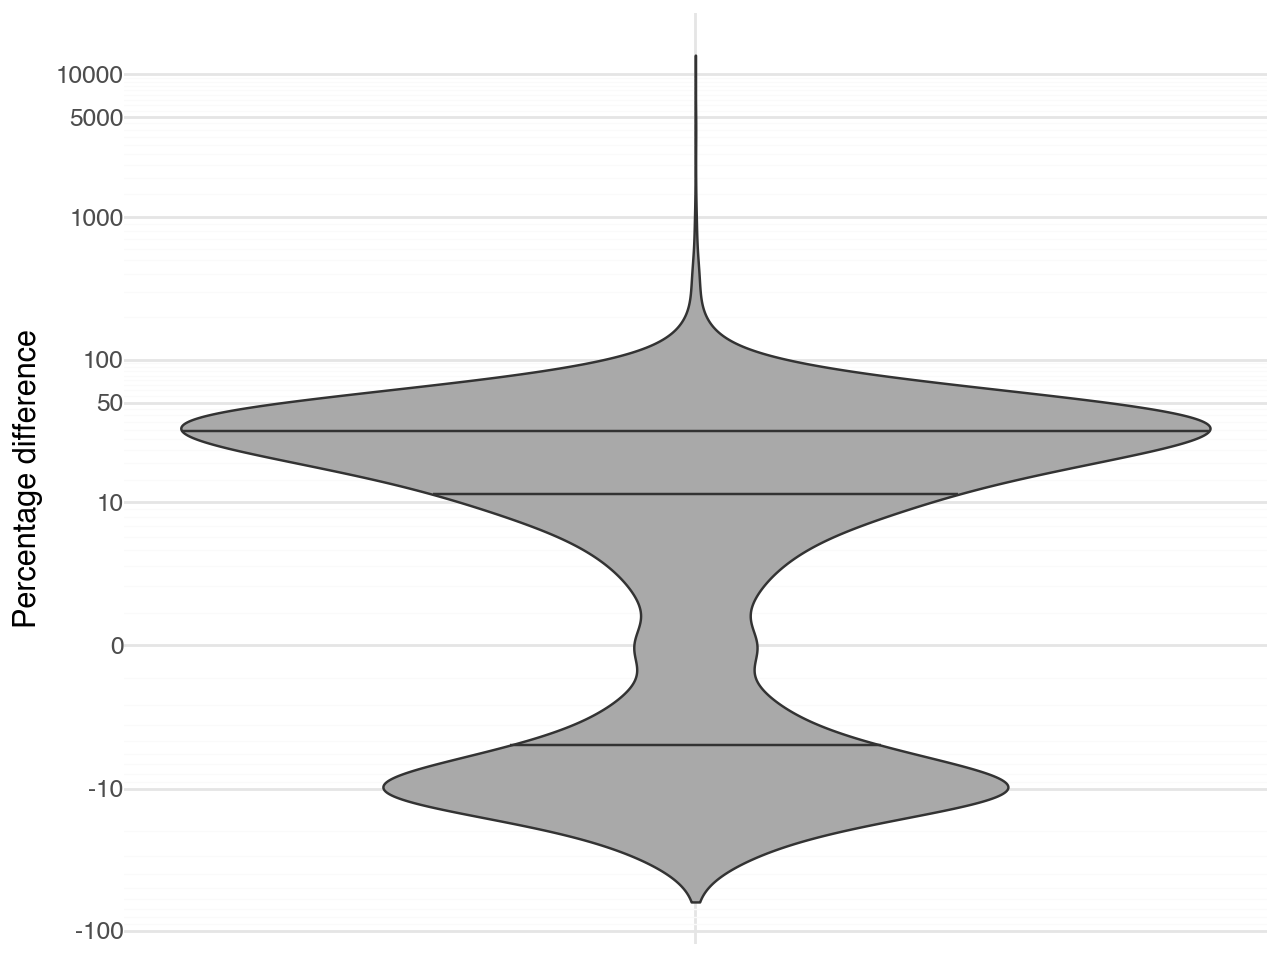

In [56]:
plot = pn.ggplot(merged_data, pn.aes(x="type", y="duration-diff")) + pn.geom_violin(fill="darkgrey", draw_quantiles=[0.25,0.5,0.75]) + pn.scale_y_continuous(trans=tr.pseudo_log_trans(base=10), breaks=[-100, -10, 0, 10, 50, 100, 1000, 5000, 10000]) + pn.ylab("Percentage difference") + pn.xlab("") + pn.theme(axis_text_x=pn.element_blank())
# plot.save(filename="runtime_diff.pdf")
plot

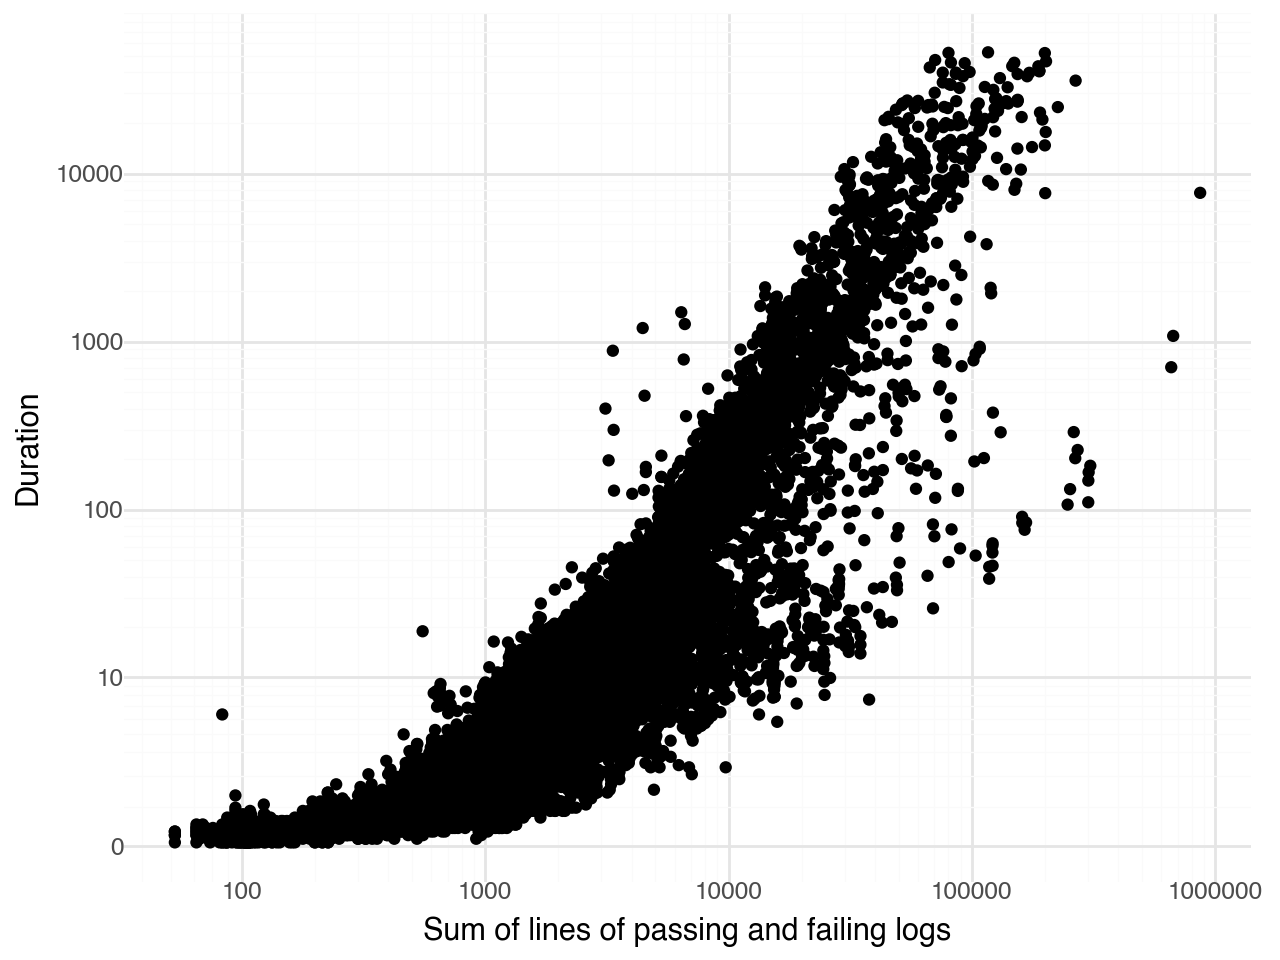

In [57]:
plot = pn.ggplot(merged_data, pn.aes(x="lines-all", y="duration")) + pn.geom_point() + pn.scale_x_continuous(trans=tr.pseudo_log_trans(base=10), breaks=[0, -10, 100, 1000, 10000, 100000, 1000000]) + pn.scale_y_continuous(trans=tr.pseudo_log_trans(base=10), breaks=[0, 10, 100, 1000, 10000, 100000]) + pn.xlab("Sum of lines of passing and failing logs") + pn.ylab("Duration") + pn.theme_minimal()
# plot.save(filename="runtime_diff.pdf", verbose=False)
plot

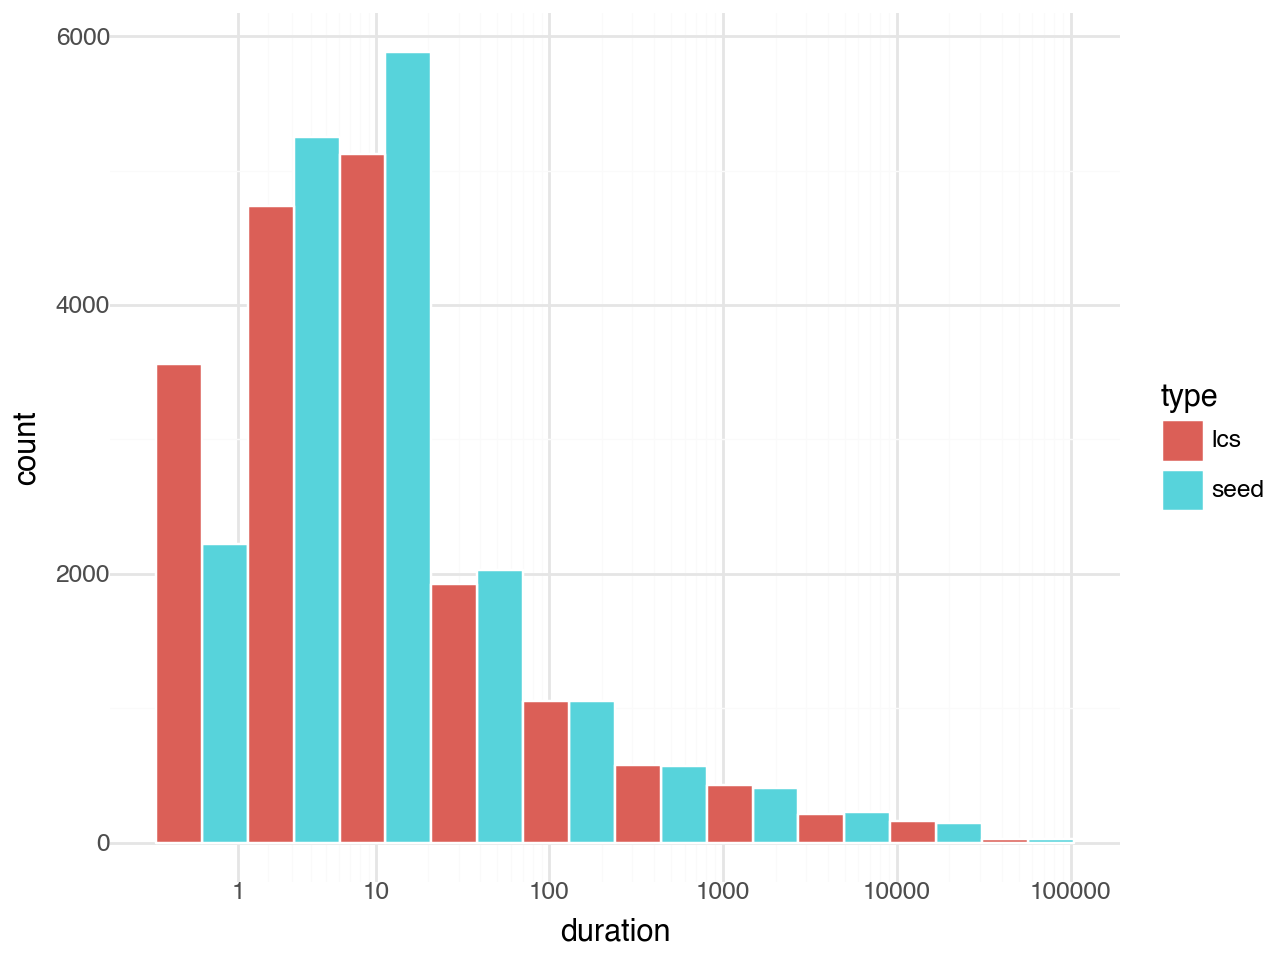

In [58]:
plot = pn.ggplot(data, pn.aes(x="duration", fill="type")) + pn.geom_histogram(bins=10, position = 'dodge', color="white") + pn.scale_x_continuous(trans=tr.pseudo_log_trans(base=10), breaks=[1, 10, 100, 1000, 10000, 100000, 1000000])
plot

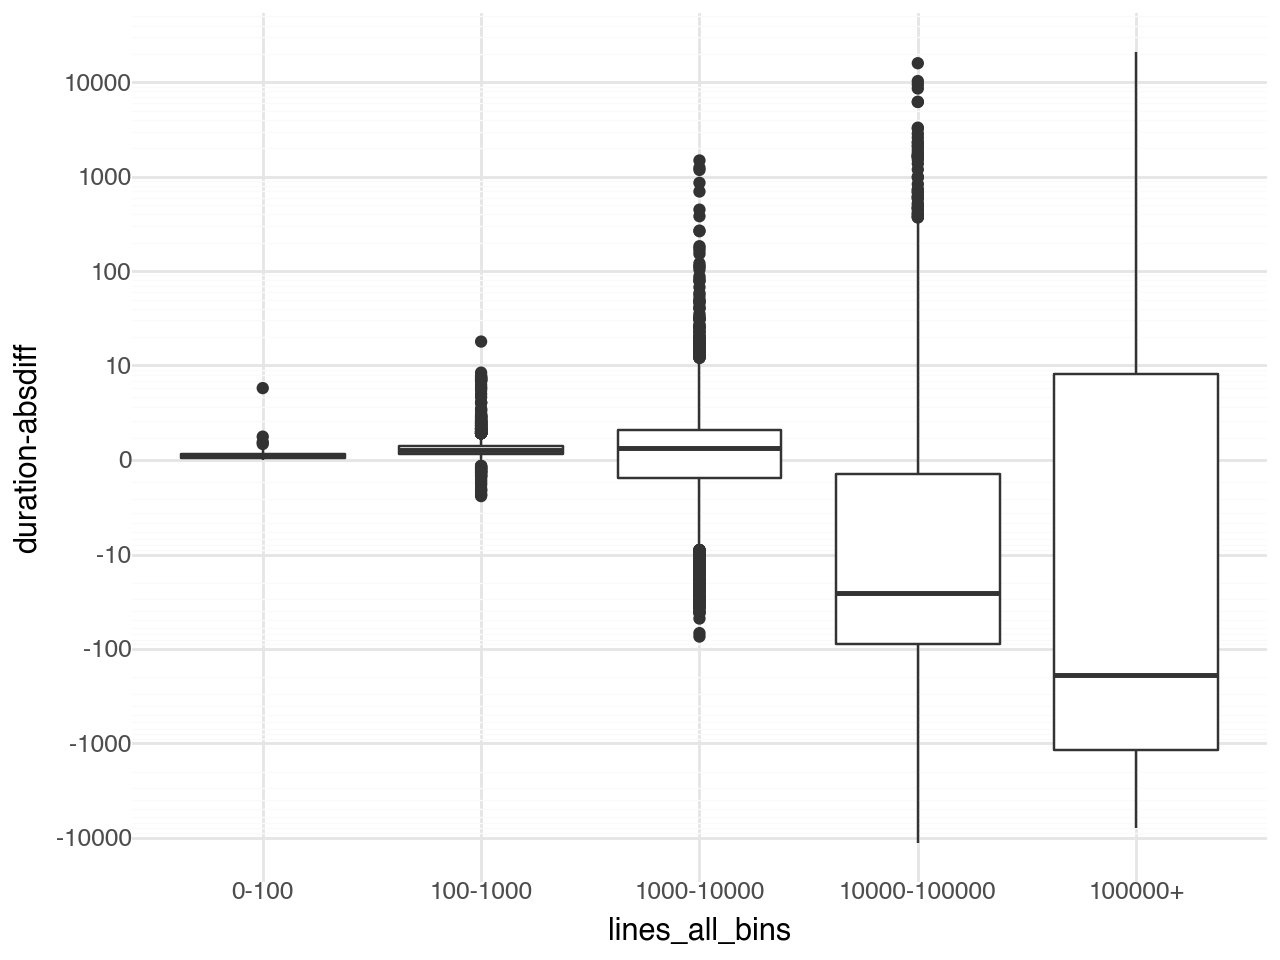

In [115]:
pn.ggplot(merged_data, pn.aes(x='lines_all_bins', y='duration-absdiff')) + pn.geom_boxplot() + pn.scale_y_continuous(trans=tr.pseudo_log_trans(base=10), breaks=[-10000, -1000, -100, -10, 0, 10, 100, 1000, 10000, 100000]) + pn.theme_minimal()

In [60]:
merged_data[merged_data["duration-absdiff"] > 10000]

,directory,type,duration,lines-left,lines-right,actions,added,deleted,updated,moved-unchanged,moved-updated,similar-groups,similar-groups-left,similar-groups-right,duration-lcs,actions-lcs,added-lcs,duration-diff,duration-absdiff,actions-diff,added-diff,lines-all,lines_all_bins
4137,nilfoundation/zkllvm/run57-0,seed,20792.8,31635,12102,28160,697,20230,664,439,6130,1917,969,948,4844.4,35393,7930,329.145169,15948.4,-20.435667,-91.199092,43737,10000-100000
6014,ansys/pyaedt/run870-0,seed,26152.7,48891,57805,32001,12667,3753,15555,22,4,1243,627,616,15771.9,47582,28248,65.814150,10380.8,-32.744888,-55.155935,106696,100000+
13573,easybuilders/easybuild/run477-0,seed,34032.7,50980,29834,49902,513,21659,27730,0,0,223,111,112,23713.1,77632,28243,43.516726,10319.6,-35.719346,-98.180144,80814,10000-100000
14891,haqq-network/haqq-wallet/run16-0,seed,35750.1,133104,133736,20518,1696,1064,682,16344,732,6755,3321,3434,14951.8,38276,19454,139.093013,20798.3,-46.393396,-91.277307,266840,100000+


## Survey Analysis

In [61]:
survey = pd.read_csv(SURVEY_FILE, sep=',')
survey.replace(to_replace={"alpha": "CiDiff", "beta": "LCS-diff", "apha": "CiDiff", "none": "None"}, inplace=True)
survey.head()

,id,side-by-side,summary,p1,p2,p3
0,bytedeco/javacpp-presets/run46-1,diff 0,None,None,None,None
1,netlify/netlify-plugin-nextjs/run4250-0,diff 1,None,None,None,CiDiff
2,python-markdown/markdown/run641-7,diff 2,None,None,None,None
3,ufbx/ufbx/run1143-4,diff 3,CiDiff,CiDiff,None,CiDiff
4,eliaskosunen/scnlib/run307-3,diff 4,None,None,None,None


In [75]:
ratios = pd.DataFrame({"p": survey["summary"].value_counts() / len(survey)}).reset_index()
ratios["p_min"] = np.maximum(ratios["p"] - 0.10, 0)
ratios["p_max"] = np.minimum(ratios["p"] + 0.10, 1)

ratios

,summary,p,p_min,p_max
0,CiDiff,0.70,0.60,0.80
1,None,0.25,0.15,0.35
2,LCS-diff,0.05,0.00,0.15


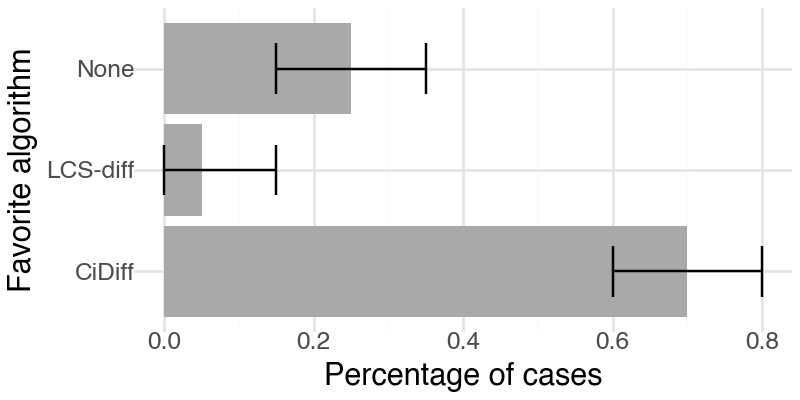

In [89]:
plot = pn.ggplot(ratios, pn.aes(x="summary", y="p")) + pn.geom_bar(stat="identity", fill="darkgrey") + pn.geom_errorbar(pn.aes(ymin="p_min", ymax="p_max")) + pn.ylab("Percentage of cases") + pn.xlab("Favorite algorithm") + pn.coord_flip() + pn.theme(figure_size=(4, 2))
# plot.save(filename="survey.pdf") 
plot

In [116]:
ratings = survey[["p1", "p2", "p3"]]
ratings["none"] = (ratings[["p1", "p2", "p3"]] == "None").sum(axis=1)
ratings["cidiff"] = (ratings[["p1", "p2", "p3"]] == "CiDiff").sum(axis=1)
ratings["lcs"] = (ratings[["p1", "p2", "p3"]] == "LCS-diff").sum(axis=1)

final_ratings = ratings[["none", "cidiff", "lcs"]]

sm.stats.inter_rater.fleiss_kappa(final_ratings, method="fleiss")

/var/folders/n_/dlsgjw2d6g96px8dr37bp7jc0000gn/T/ipykernel_88233/793957973.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/n_/dlsgjw2d6g96px8dr37bp7jc0000gn/T/ipykernel_88233/793957973.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


np.float64(0.24551386623164734)

In [65]:
survey[survey["summary"] == "LCS-diff"]

,id,side-by-side,summary,p1,p2,p3
72,kreneskyp/ix/run573-0,diff 72,LCS-diff,CiDiff,LCS-diff,LCS-diff
75,apollographql/apollo-client-nextjs/run24-0,diff 75,LCS-diff,CiDiff,LCS-diff,LCS-diff
82,npm/ini/run266-17,diff 82,LCS-diff,CiDiff,LCS-diff,LCS-diff
84,flathunters/flathunter/run634-0,diff 84,LCS-diff,CiDiff,LCS-diff,LCS-diff
89,mohsenabrishami/stethoscope/run554-0,diff 89,LCS-diff,CiDiff,LCS-diff,LCS-diff
